In [24]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


#  Instance Segmentation for Campus Waste Detection Using Mask R-CNN  
This notebook walks through:
1. **Data preparation & remapping** of categories  
2. **Dataset registration** (train/val/test split)  
3. **Hyperparameter tuning** with validation  
4. **Final training** on the best config  
5. **Evaluation** on the test set  
6. **Visualization** of predictions vs. ground truth  

In [25]:
# --- Cell 1: Mount Google Drive (Colab Only) ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    print("Skipping drive.mount(); not in Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# --- Cell 2: Imports & Setup ---
import os
import json
import torch
import numpy as np

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.events import JSONWriter
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

## Cell 3: Remap Original COCO JSON to Two Categories  
`0,1 → recyclable_container (1)`  
`2,3 → food_packaging (2)`

In [27]:
# Paths
orig_json     = "/content/drive/MyDrive/waste_project/coco_annotations.json"
remapped_json = "/content/drive/MyDrive/waste_project/coco_annotations_remapped.json"

# Load and remap
with open(orig_json) as f:
    coco = json.load(f)

remap = {0: 1, 1: 1, 2: 2, 3: 2}
new_categories = [
    {"id": 1, "name": "recyclable_container"},
    {"id": 2, "name": "food_packaging"},
]
for ann in coco["annotations"]:
    ann["category_id"] = remap[ann["category_id"]]

coco["categories"] = new_categories
with open(remapped_json, "w") as f:
    json.dump(coco, f)
print("Saved remapped JSON to", remapped_json)

Saved remapped JSON to /content/drive/MyDrive/waste_project/coco_annotations_remapped.json


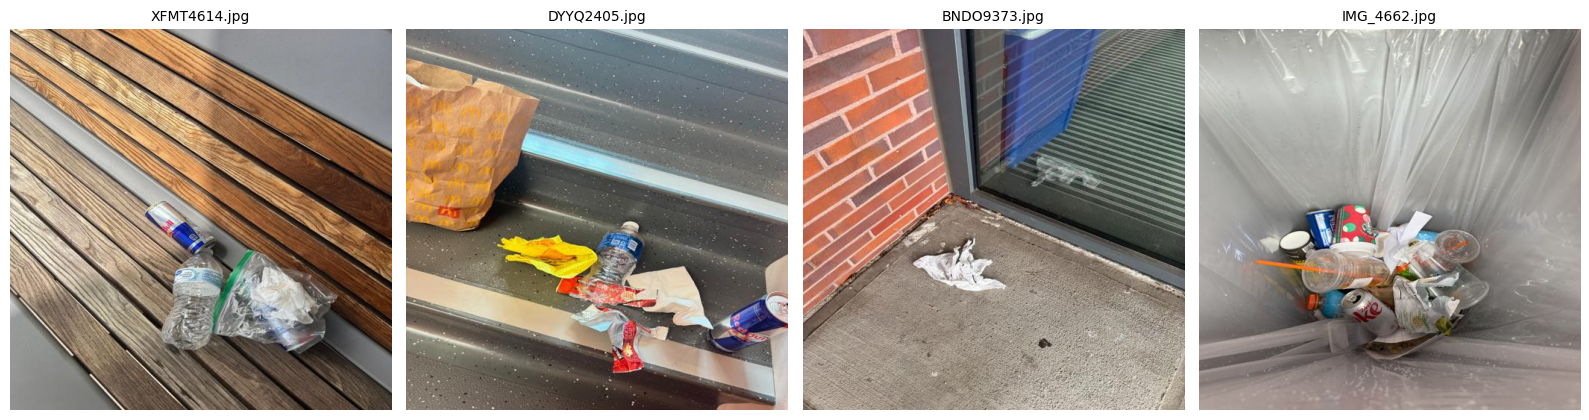

In [28]:
# ## Display Sample Campus Waste Images

import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# use the exact image folder from your PDF :contentReference[oaicite:0]{index=0}
dataset_dir = "/content/drive/MyDrive/waste_project/resized_images"

# Collect all JPG/PNG files
image_files = [
    f for f in os.listdir(dataset_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

# Pick 4 at random (change k for more/less)
random.seed(42)
sample_files = random.sample(image_files, k=4)

# Plot them
fig, axes = plt.subplots(1, len(sample_files), figsize=(16, 6))
for ax, fname in zip(axes, sample_files):
    img = Image.open(os.path.join(dataset_dir, fname))
    ax.imshow(img)
    ax.set_title(fname, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Cell 4: Load, Split & Register Datasets  
80% Train, 10% Val, 10% Test

In [29]:
# Helper to load COCO-format into Detectron2
def load_coco(path_json, img_dir):
    data = json.load(open(path_json))
    id2img = {img["id"]: img for img in data["images"]}
    anns_by_img = {}
    for ann in data["annotations"]:
        anns_by_img.setdefault(ann["image_id"], []).append({
            "bbox": ann["bbox"],
            "bbox_mode": BoxMode.XYWH_ABS,
            "category_id": ann["category_id"] - 1,
            "segmentation": ann["segmentation"],
        })
    records = []
    for img_id, info in id2img.items():
        fname = os.path.join(img_dir, info["file_name"])
        if not os.path.exists(fname):
            continue
        rec = {
            "file_name": fname,
            "image_id": img_id,
            "height": info["height"],
            "width": info["width"],
            "annotations": anns_by_img.get(img_id, [])
        }
        if rec["annotations"]:
            records.append(rec)
    return records

# Paths and split
img_dir = "/content/drive/MyDrive/waste_project/resized_images"
dataset = load_coco(remapped_json, img_dir)
np.random.seed(42)
np.random.shuffle(dataset)
n = len(dataset)
train_ds = dataset[: int(0.8 * n)]
val_ds   = dataset[int(0.8 * n): int(0.9 * n)]
test_ds  = dataset[int(0.9 * n): ]

for name, ds in [("waste_train", train_ds), ("waste_val", val_ds), ("waste_test", test_ds)]:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
    DatasetCatalog.register(name, lambda ds=ds: ds)
    MetadataCatalog.get(name).set(thing_classes=["recyclable_container","food_packaging"])

print(f"Registered: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

Registered: train=160, val=20, test=20


## Cell 5: Hyperparameter Tuning & Validation  

We’ll sweep over learning rates and iteration counts, train on `waste_train`, validate on `waste_val`.

In [30]:
def train_and_eval_once(lr, max_iter, outdir):
    cfg = get_cfg()
    cfg.merge_from_file(
        model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    )
    cfg.DATASETS.TRAIN = ("waste_train",)
    cfg.DATASETS.TEST  = ("waste_val",)
    cfg.MODEL.WEIGHTS  = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    )
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
    cfg.SOLVER.IMS_PER_BATCH  = 4
    cfg.SOLVER.BASE_LR        = lr
    cfg.SOLVER.MAX_ITER       = max_iter    # very small for scan
    cfg.OUTPUT_DIR            = outdir
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    # train
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    # eval
    evaluator = COCOEvaluator("waste_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
    val_loader = build_detection_test_loader(cfg, "waste_val")
    metrics = inference_on_dataset(trainer.model, val_loader, evaluator)
    return metrics["bbox"]["AP"]

lr_candidates   = [1e-4, 2.5e-4, 5e-4]
fast_iters      = 200   # <<<< only 200 iters per trial
best_lr, best_ap = None, 0.0
for lr in lr_candidates:
    ap = train_and_eval_once(lr, fast_iters, f"output/quick_{lr}")
    print(f"→ LR={lr:.1e} @ {fast_iters} iters → AP={ap:.4f}")
    if ap > best_ap:
        best_ap, best_lr = ap, lr

print(f"🏆 Best coarse LR = {best_lr:.1e} (AP={best_ap:.4f})")

[04/30 02:57:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/30 02:57:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/30 02:58:16 d2.utils.events]:  eta: 0:02:22  iter: 19  total_loss: 2.07  loss_cls: 1.043  loss_box_reg: 0.2985  loss_mask: 0.6927  loss_rpn_cls: 0.01783  loss_rpn_loc: 0.007733    time: 0.7985  last_time: 0.6676  data_time: 0.0396  last_data_time: 0.0121   lr: 9.5905e-06  max_mem: 3441M
[04/30 02:58:35 d2.utils.events]:  eta: 0:02:06  iter: 39  total_loss: 1.836  loss_cls: 0.8729  loss_box_reg: 0.2811  loss_mask: 0.6801  loss_rpn_cls: 0.0116  loss_rpn_loc: 0.007212    time: 0.7883  last_time: 0.7905  data_time: 0.0205  last_data_time: 0.0103   lr: 1.958e-05  max_mem: 3441M
[04/30 02:58:51 d2.utils.events]:  eta: 0:01:50  iter: 59  total_loss: 1.506  loss_cls: 0.5575  loss_box_reg: 0.264  loss_mask: 0.6467  loss_rpn_cls: 0.01353  loss_rpn_loc: 0.007767    time: 0.7895  last_time: 0.7576  data_time: 0.0164  last_data_time: 0.0101   lr: 2.9571e-05  max_mem: 3441M
[04/30 02:59:07 d2.utils.events]:  eta: 0:01:34  iter: 79  total_loss: 1.364  loss_cls: 0.385  loss_box_reg: 0.3031  loss_m

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[04/30 03:00:48 d2.evaluation.evaluator]: Inference done 11/20. Dataloading: 0.0009 s/iter. Inference: 0.0937 s/iter. Eval: 0.0279 s/iter. Total: 0.1226 s/iter. ETA=0:00:01
[04/30 03:00:49 d2.evaluation.evaluator]: Total inference time: 0:00:02.179783 (0.145319 s / iter per device, on 1 devices)
[04/30 03:00:49 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.095888 s / iter per device, on 1 devices)
[04/30 03:00:49 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/30 03:00:49 d2.evaluation.coco_evaluation]: Saving results to output/quick_0.0001/coco_instances_results.json
[04/30 03:00:49 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDet

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/30 03:00:51 d2.engine.train_loop]: Starting training from iteration 0
[04/30 03:01:08 d2.utils.events]:  eta: 0:02:27  iter: 19  total_loss: 2.125  loss_cls: 1.097  loss_box_reg: 0.3013  loss_mask: 0.6891  loss_rpn_cls: 0.014  loss_rpn_loc: 0.009115    time: 0.8082  last_time: 0.8014  data_time: 0.0482  last_data_time: 0.0109   lr: 2.3976e-05  max_mem: 3441M
[04/30 03:01:23 d2.utils.events]:  eta: 0:02:08  iter: 39  total_loss: 1.577  loss_cls: 0.6464  loss_box_reg: 0.2931  loss_mask: 0.6545  loss_rpn_cls: 0.0117  loss_rpn_loc: 0.006913    time: 0.7912  last_time: 0.7259  data_time: 0.0212  last_data_time: 0.0151   lr: 4.8951e-05  max_mem: 3441M
[04/30 03:01:39 d2.utils.events]:  eta: 0:01:50  iter: 59  total_loss: 1.19  loss_cls: 0.3048  loss_box_reg: 0.279  loss_mask: 0.5825  loss_rpn_cls: 0.01617  loss_rpn_loc: 0.006357    time: 0.7841  last_time: 0.8109  data_time: 0.0134  last_data_time: 0.0180   lr: 7.3926e-05  max_mem: 3441M
[04/30 03:01:55 d2.utils.events]:  eta: 0:01:36  i

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[04/30 03:03:36 d2.evaluation.evaluator]: Inference done 11/20. Dataloading: 0.0014 s/iter. Inference: 0.0903 s/iter. Eval: 0.0235 s/iter. Total: 0.1152 s/iter. ETA=0:00:01
[04/30 03:03:37 d2.evaluation.evaluator]: Total inference time: 0:00:01.843724 (0.122915 s / iter per device, on 1 devices)
[04/30 03:03:37 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.090752 s / iter per device, on 1 devices)
[04/30 03:03:37 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/30 03:03:37 d2.evaluation.coco_evaluation]: Saving results to output/quick_0.00025/coco_instances_results.json
[04/30 03:03:37 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDe

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/30 03:03:38 d2.engine.train_loop]: Starting training from iteration 0
[04/30 03:03:54 d2.utils.events]:  eta: 0:02:24  iter: 19  total_loss: 1.905  loss_cls: 0.9236  loss_box_reg: 0.3041  loss_mask: 0.6888  loss_rpn_cls: 0.01494  loss_rpn_loc: 0.00866    time: 0.7944  last_time: 0.7929  data_time: 0.0359  last_data_time: 0.0154   lr: 4.7953e-05  max_mem: 3441M
[04/30 03:04:11 d2.utils.events]:  eta: 0:02:09  iter: 39  total_loss: 1.309  loss_cls: 0.3889  loss_box_reg: 0.2917  loss_mask: 0.6227  loss_rpn_cls: 0.01364  loss_rpn_loc: 0.007524    time: 0.8059  last_time: 0.8822  data_time: 0.0171  last_data_time: 0.0253   lr: 9.7903e-05  max_mem: 3441M
[04/30 03:04:27 d2.utils.events]:  eta: 0:01:53  iter: 59  total_loss: 1.044  loss_cls: 0.2437  loss_box_reg: 0.2864  loss_mask: 0.4868  loss_rpn_cls: 0.01185  loss_rpn_loc: 0.006633    time: 0.8039  last_time: 0.7464  data_time: 0.0195  last_data_time: 0.0246   lr: 0.00014785  max_mem: 3441M
[04/30 03:04:43 d2.utils.events]:  eta: 0:01:

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[04/30 03:06:24 d2.evaluation.evaluator]: Inference done 11/20. Dataloading: 0.0029 s/iter. Inference: 0.0881 s/iter. Eval: 0.0151 s/iter. Total: 0.1062 s/iter. ETA=0:00:00
[04/30 03:06:25 d2.evaluation.evaluator]: Total inference time: 0:00:01.597545 (0.106503 s / iter per device, on 1 devices)
[04/30 03:06:25 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.085875 s / iter per device, on 1 devices)
[04/30 03:06:25 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/30 03:06:25 d2.evaluation.coco_evaluation]: Saving results to output/quick_0.0005/coco_instances_results.json
[04/30 03:06:25 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDet

#Cell 6: Merge train & val → `waste_trainval`


In [31]:
# merge your Python lists
merged = train_ds + val_ds

# register
DatasetCatalog.register("waste_trainval", lambda ds=merged: merged)
MetadataCatalog.get("waste_trainval").set(
    thing_classes=["recyclable_container","food_packaging"]
)

print(f"✅ Registered waste_trainval ({len(merged)} images)")

✅ Registered waste_trainval (180 images)


## Cell 7: Final training with `best_lr` & full iters, then evaluate on `waste_test`


In [32]:
# hyperparams
full_iters = 1000
outdir     = f"/content/drive/MyDrive/waste_project/output/final_{best_lr:.1e}_{full_iters}"

# re‐build cfg
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)
cfg.DATASETS.TRAIN              = ("waste_trainval",)
cfg.DATASETS.TEST               = ("waste_test",)
cfg.MODEL.WEIGHTS               = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.SOLVER.IMS_PER_BATCH        = 4
cfg.SOLVER.BASE_LR              = best_lr
cfg.SOLVER.MAX_ITER             = full_iters
cfg.OUTPUT_DIR                  = outdir

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# test eval
evaluator   = COCOEvaluator("waste_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
test_loader = build_detection_test_loader(cfg, "waste_test")
test_metrics = inference_on_dataset(trainer.model, test_loader, evaluator)
print("📊 Test set metrics:", test_metrics)

[04/30 03:06:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/30 03:06:27 d2.engine.train_loop]: Starting training from iteration 0
[04/30 03:06:44 d2.utils.events]:  eta: 0:13:51  iter: 19  total_loss: 1.993  loss_cls: 0.9901  loss_box_reg: 0.3055  loss_mask: 0.69  loss_rpn_cls: 0.01207  loss_rpn_loc: 0.008498    time: 0.8450  last_time: 0.7166  data_time: 0.0550  last_data_time: 0.0103   lr: 9.9905e-06  max_mem: 3613M
[04/30 03:07:00 d2.utils.events]:  eta: 0:12:57  iter: 39  total_loss: 1.827  loss_cls: 0.817  loss_box_reg: 0.2928  loss_mask: 0.6783  loss_rpn_cls: 0.01831  loss_rpn_loc: 0.007951    time: 0.8218  last_time: 0.7945  data_time: 0.0182  last_data_time: 0.0339   lr: 1.998e-05  max_mem: 3614M
[04/30 03:07:16 d2.utils.events]:  eta: 0:12:33  iter: 59  total_loss: 1.497  loss_cls: 0.5342  loss_box_reg: 0.2867  loss_mask: 0.6492  loss_rpn_cls: 0.0117  loss_rpn_loc: 0.007323    time: 0.8071  last_time: 0.9163  data_time: 0.0179  last_data_time: 0.0247   lr: 2.997e-05  max_mem: 3614M
[04/30 03:07:32 d2.utils.events]:  eta: 0:12:18  i

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[04/30 03:20:14 d2.evaluation.evaluator]: Inference done 11/20. Dataloading: 0.0024 s/iter. Inference: 0.0897 s/iter. Eval: 0.0045 s/iter. Total: 0.0966 s/iter. ETA=0:00:00
[04/30 03:20:15 d2.evaluation.evaluator]: Total inference time: 0:00:01.565102 (0.104340 s / iter per device, on 1 devices)
[04/30 03:20:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.086652 s / iter per device, on 1 devices)
[04/30 03:20:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/30 03:20:15 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/waste_project/output/final_5.0e-04_1000/coco_instances_results.json
[04/30 03:20:15 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (

### Cell 8: Build a `DefaultPredictor` for inference



In [33]:
from detectron2.engine import DefaultPredictor

# switch weights to your trained final model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # you can adjust this

predictor = DefaultPredictor(cfg)
print("🔍 Predictor ready (threshold =", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST, ")")

[04/30 03:20:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/waste_project/output/final_5.0e-04_1000/model_final.pth ...
🔍 Predictor ready (threshold = 0.5 )


## Cell 9: Visualize Predictions vs. Ground-Truth on Test Images


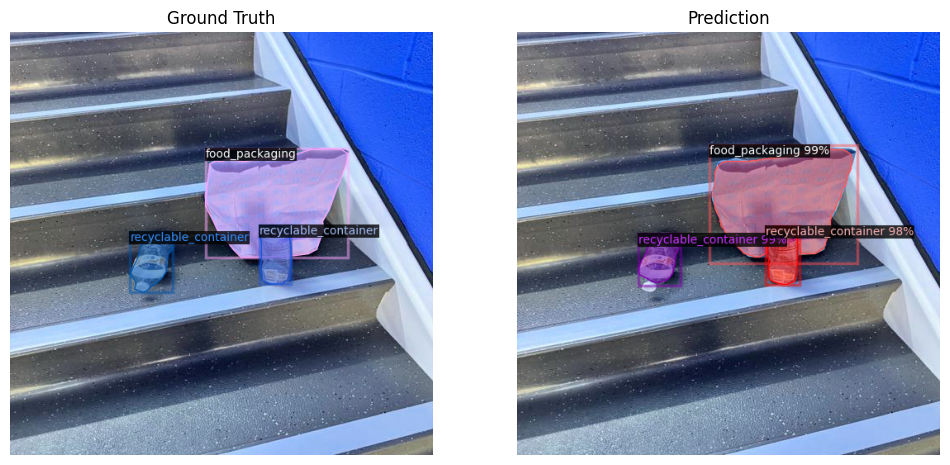

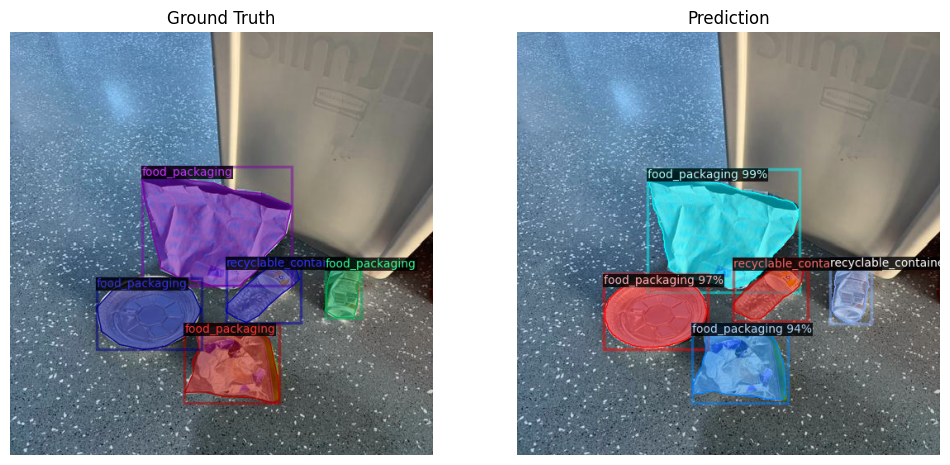

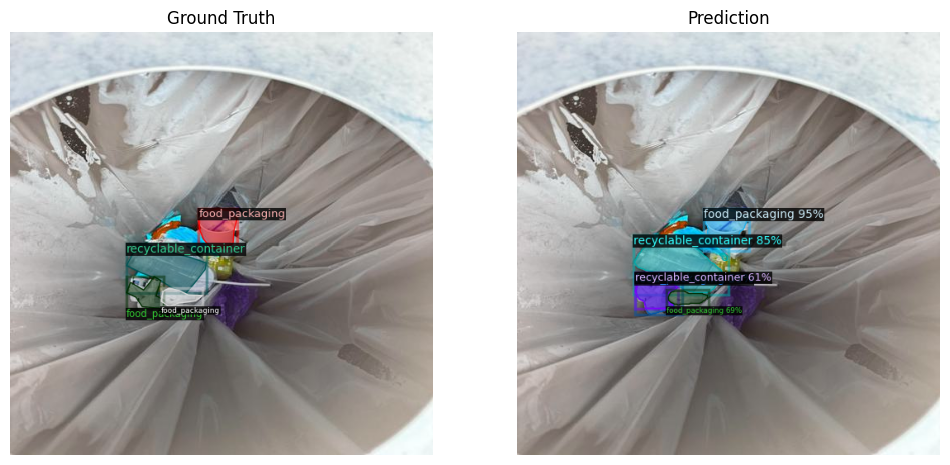

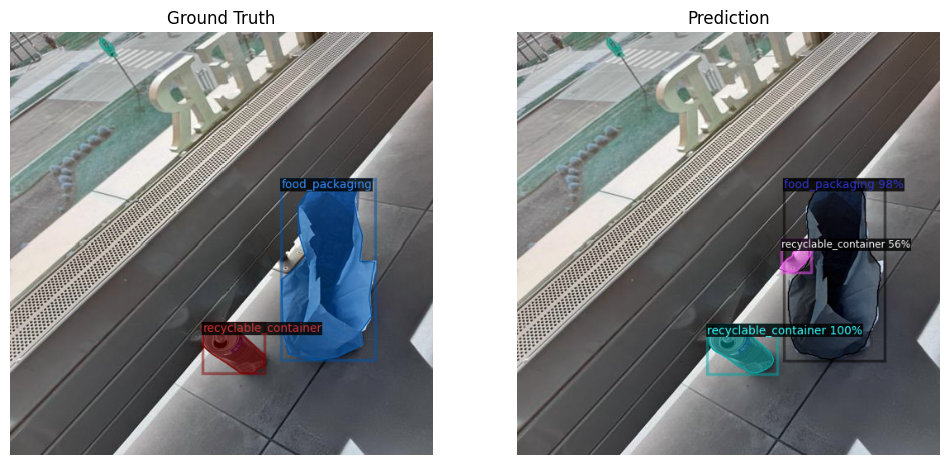

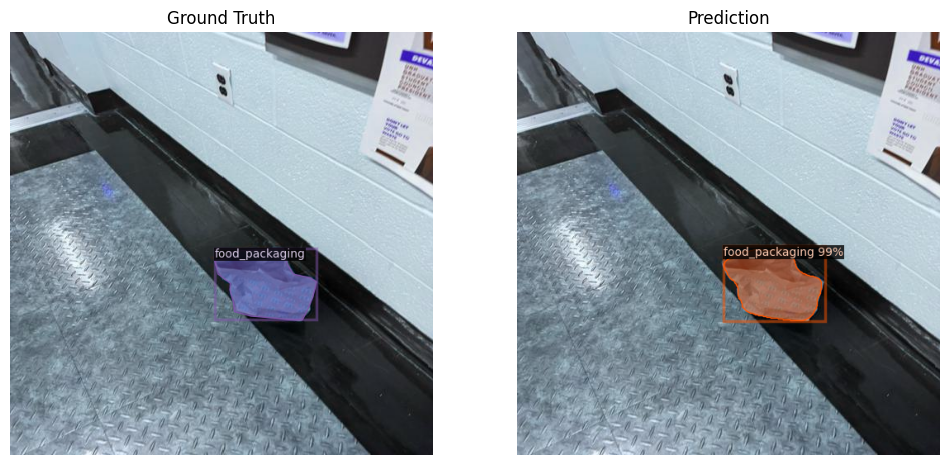

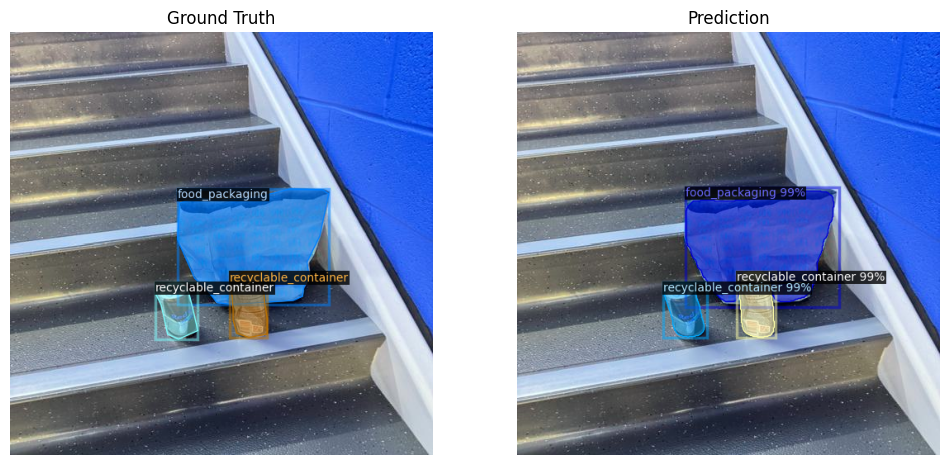

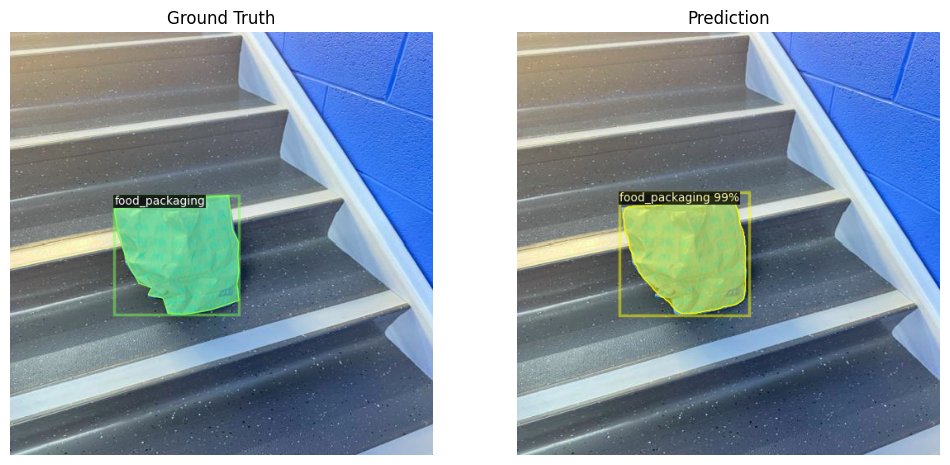

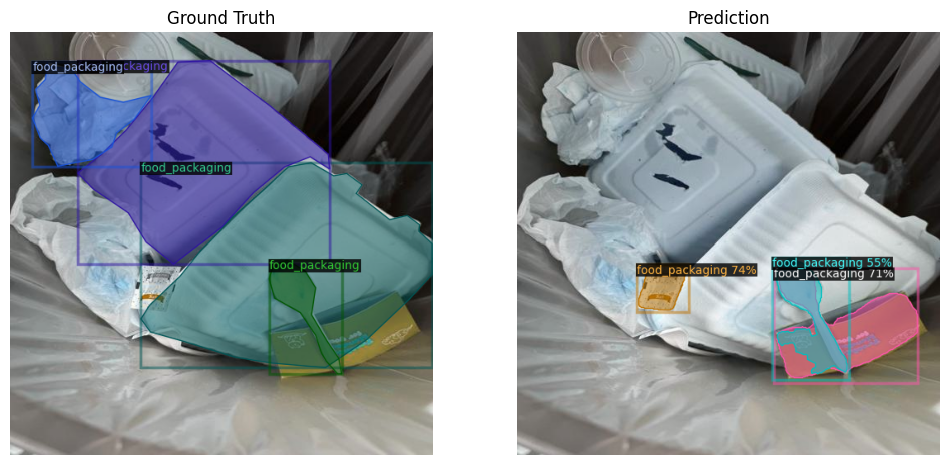

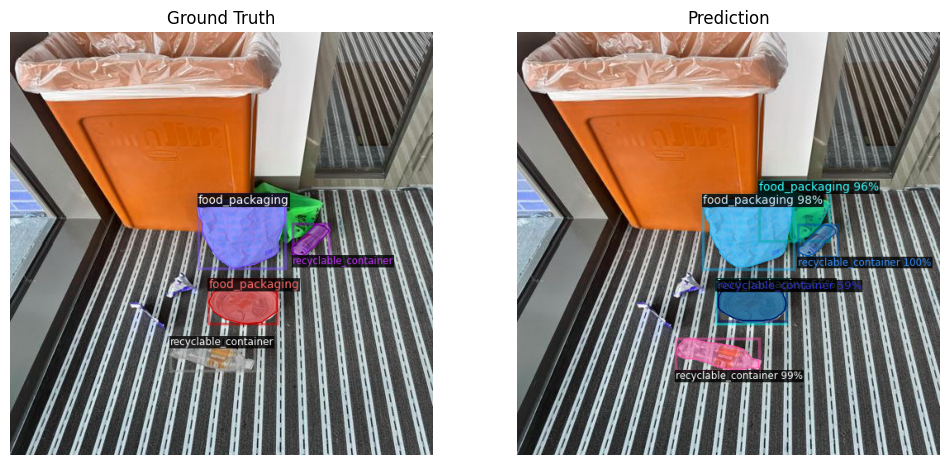

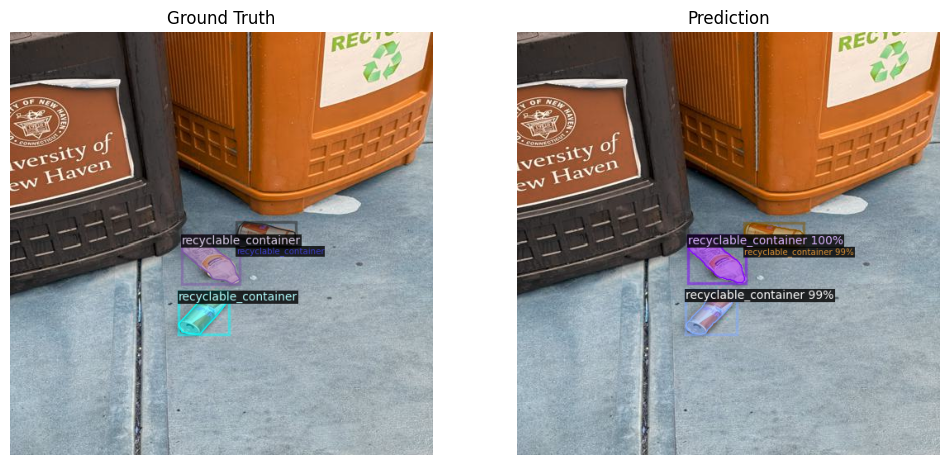

In [34]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

test_ds = DatasetCatalog.get("waste_test")

for rec in test_ds[:10]:
    img = cv2.imread(rec["file_name"])

    # draw GT
    v_gt   = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("waste_trainval"))
    out_gt = v_gt.draw_dataset_dict(rec)

    # draw predictions
    outputs  = predictor(img)
    v_pred   = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("waste_trainval"))
    out_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))

    # plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(out_gt.get_image()[:, :, ::-1])
    ax1.set_title("Ground Truth"); ax1.axis("off")
    ax2.imshow(out_pred.get_image()[:, :, ::-1])
    ax2.set_title("Prediction");  ax2.axis("off")
    plt.show()

### Cell 10: Launch Gradio App

In [35]:
!pip install --quiet gradio

import gradio as gr

meta_full = MetadataCatalog.get("waste_trainval")

def segment_waste(image: np.ndarray):
    # Gradio provides RGB
    outputs = predictor(image[:, :, ::-1])  # to BGR
    v = Visualizer(image, metadata=meta_full, scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    return out.get_image()

iface = gr.Interface(
    fn=segment_waste,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Image(type="numpy"),
    title="Waste Segmentation",
    description="Detect recyclable containers vs. food packaging",
    allow_flagging="never"
)
iface.launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8a63770cf6102e8c26.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
